In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from prettytable import PrettyTable
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
X = load_boston().data
Y = load_boston().target

In [3]:
X_tr, X_te, y_tr, y_te = train_test_split(X, Y, test_size=.33)

In [4]:
scaler = preprocessing.StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_te = scaler.transform(X_te)

## 1. Custom SGD implementation

In [15]:
np.hstack((np.ones((X_tr.shape[0],1)), X_tr)).shape

(339, 14)

In [8]:
np.ones((X_tr.shape[0],1))

(339, 1)

In [16]:
class CustomSGDLinearRegressor:
    
    def __init__(self, learning_rate, iters, k_rand_points):
        self.w = None
        self.b = None
        self.X = None
        self.y = None
        self.r = learning_rate
        self.k = k_rand_points
        self.iters = iters
        
    def fit(self, DTrain, y):
        
        self.X = np.array(DTrain)
        self.X = np.hstack( (np.ones( (self.X.shape[0], 1) ), self.X) )
        self.y = np.array(y).reshape(-1)
        self.w = np.random.normal(size = self.X.shape[1])
        self.b = np.random.normal()
        
        for _ in range( self.iters // self.k + 1):
#             self.findBestBias()
            self.findBestWeights()
    
    def findBestWeights(self):
        
        opt_weights = self.w
        r = self.r
        
        for _ in range(self.iters - 1):
            opt_weights = opt_weights + ( r * 2 * self.selectKPointsforWeights( opt_weights ) ) / self.k
            
            r /= 2
        
        self.w = opt_weights
            
    def selectKPointsforWeights(self, weights):
        
        idxs = np.random.randint(0, self.X.shape[0], size = self.k)
        
        return (self.X[idxs] * (self.y[idxs] - (weights * self.X[idxs]).sum(axis=1) - self.b).reshape(-1,1)).sum(axis=0)
        
    def findBestBias(self):
        
        opt_b = self.b
        r = self.r
        
        for _ in range(self.iters - 1):
            opt_b = opt_b + ( r * 2 * self.selectKPointsforBias( opt_b ) ) / self.k
                
            r /= 2
        
        self.b = opt_b
            
    def selectKPointsforBias(self, bias):
        
        idxs = np.random.randint(0, self.X.shape[0], size = self.k)
        
        return (self.y[idxs] - (self.w * self.X[idxs]).sum(axis=1) - bias).sum()
        
    def predict(self, DTest):
        
        DTest = np.array(DTest)
        DTest = np.hstack( (np.ones( (DTest.shape[0], 1) ), DTest) )

#         return np.round( (self.w* DTest).sum(axis=1) + self.b, 1 )        

        return np.round( (self.w* DTest).sum(axis=1), 1 )

In [75]:
model = CustomSGDLinearRegressor(learning_rate = .25, iters = 1000, k_rand_points = 200)

### 1.1 Finding best weights using CustomSGD

In [85]:
model.fit(X_tr, y_tr)

print('Custom SGD Weights:\n\n', model.w)

print('\nCustom SGD MSE:', mean_squared_error(y_te, model.predict(X_te)))

Custom SGD Weights:

 [24.10257121 -0.69651017  0.26599504 -0.58685864  0.70911331 -1.18362323
  3.14452066 -0.23278986 -1.88314046  1.10465033 -0.39798162 -1.83181956
  0.94932447 -3.55189254]

Custom SGD MSE: 26.37197604790419


### 1.2 Plotting Actual vs Predicted values for CustomSGD

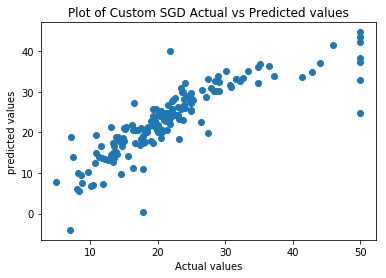

In [88]:
plt.scatter(y_te, model.predict(X_te))
plt.xlabel('Actual values')
plt.ylabel('predicted values')
plt.title('Plot of Custom SGD Actual vs Predicted values')
plt.show()

## 2. SKLearn SGDRegressor

In [26]:
clf = SGDRegressor()

### 2.1 Finding best weights using SKLearn SGDRegressor

In [86]:
clf.fit(X_tr, y_tr)

print('SKLearn\'s SGD Regressor Weights:\n\n', clf.coef_)

print('\nSKLearn\'s SGD Regressor MSE:', mean_squared_error(y_te, clf.predict(X_te)))

SKLearn's SGD Regressor Weights:

 [-0.89604951  0.30321462 -0.76636848  0.72957645 -0.55468706  3.17536303
 -0.09014438 -1.68772763  0.83585945 -0.46267422 -1.75479339  0.95253289
 -3.55558391]

SKLearn's SGD Regressor MSE: 26.274725914254613


### 1.2 Plotting Actual vs Predicted values for SKLearn SGDRegressor

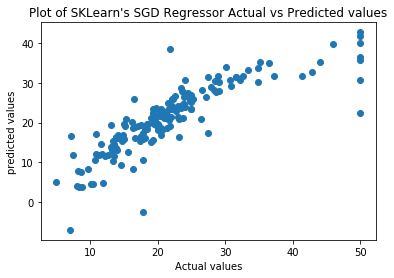

In [89]:
plt.scatter(y_te, clf.predict(X_te))
plt.xlabel('Actual values')
plt.ylabel('predicted values')
plt.title('Plot of SKLearn\'s SGD Regressor Actual vs Predicted values')
plt.show()

## 3. Weights of SGDRegressor vs CustomSGD

In [87]:
pt = PrettyTable()
pt.field_names = ['Component of Weight', 'SKLearn SGDRegressor', 'Custom SGD']

for idx, weights in enumerate(zip(clf.coef_, model.w)):
    pt.add_row([ idx+1, *weights ])

print(pt)

+---------------------+----------------------+----------------------+
| Component of Weight | SKLearn SGDRegressor |      Custom SGD      |
+---------------------+----------------------+----------------------+
|          1          | -0.8960495111745226  |  24.10257120519149   |
|          2          | 0.30321461752582674  | -0.6965101709961905  |
|          3          | -0.7663684771290054  | 0.26599503823851617  |
|          4          |  0.7295764457717323  | -0.5868586416127755  |
|          5          | -0.5546870606491076  |  0.7091133133331444  |
|          6          |  3.1753630328087374  |  -1.183623233545351  |
|          7          | -0.09014437670582084 |  3.1445206561751466  |
|          8          | -1.6877276326152442  | -0.23278985836586183 |
|          9          |  0.8358594489064398  | -1.8831404550808866  |
|          10         | -0.46267422204143477 |  1.104650329274077   |
|          11         | -1.7547933915371763  | -0.3979816184193776  |
|          12       

## 4. Mean Squared Error of SGDRegressor vs CustomSGD

In [25]:
pt = PrettyTable()

pt.field_names = ['Metric', 'SKLearn SGDRegressor', 'Custom SGDLinearRegressor']

pt.add_row(['MSE', mean_squared_error(y_te, clf.predict(X_te)), mean_squared_error(y_te, model.predict(X_te))])

print(pt)

+--------+----------------------+---------------------------+
| Metric | SKLearn SGDRegressor | Custom SGDLinearRegressor |
+--------+----------------------+---------------------------+
|  MSE   |  22.398904939024018  |      22.1897005988024     |
+--------+----------------------+---------------------------+
